<a href="https://colab.research.google.com/github/Engineer-Ayesha-Shafique/ImageSpeak-Image-Caption-Generator-using-Flickr8k-Dataset/blob/main/ImageSpeak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Drive and downloading dataset from kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [3]:
%cd /content/drive/MyDrive/Kaggle/flickr8k/

/content/drive/MyDrive/Kaggle/flickr8k


In [4]:
%ls

BestModel     EncodedImageTrainResNet.pkl  Images/
captions.txt  EncodedImageValidResNet.pkl  kaggle.json


In [5]:
# !kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [00:11<00:00, 62.2MB/s]
100% 1.04G/1.04G [00:11<00:00, 94.9MB/s]


In [ ]:
# !unzip flickr8k.zip

In [5]:
%ls

BestModel     EncodedImageTrainResNet.pkl  Images/
captions.txt  EncodedImageValidResNet.pkl  kaggle.json


In [6]:
%cd Images
%ls . | wc -l
%cd ..

/content/drive/MyDrive/Kaggle/flickr8k/Images
8091
/content/drive/MyDrive/Kaggle/flickr8k


## ImageSpeak Image Caption Generator using ResNet and Transformer Decoder Model. It can be divided into 2 steps :
### **Step 1** : Create features for Images Using Resnet
### **Step 2** : Train Transformer Decoder Model which predicts next word given a sequence of tokens and Image Features from Step1


In [7]:
# Importing necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
from collections import Counter  # For counting elements in a collection
import torchvision  # For computer vision tasks using PyTorch
from torchvision import transforms  # For image transformations
from PIL import Image  # For handling images
from torch.utils.data import Dataset, DataLoader  # For creating custom datasets and data loading
import torch  # The main PyTorch library
import torch.nn as nn  # For building neural networks
from torch.autograd import Variable  # For automatic differentiation
from tqdm.notebook import tqdm  # For displaying progress bars
import matplotlib.pyplot as plt  # For plotting graphs and images
import math  # For mathematical functions
import torch.nn.functional as F  # For additional functional operations in PyTorch
import pickle  # For serializing and deserializing Python objects
import gc  # For garbage collection
import random  # For generating random numbers
pd.set_option('display.max_colwidth', None)  # To display full column width in Pandas

## **Read Data**

In [8]:
# Reading captions from a CSV file into a Pandas DataFrame
df = pd.read_csv("captions.txt", sep=',')
# Displaying the length of the DataFrame
print(f"Number of entries in the DataFrame: {len(df)}")
# Displaying the first 3 rows of the DataFrame
display(df.head(3))

Number of entries in the DataFrame: 40455


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   

                                                                    caption  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .  
2                          A little girl climbing into a wooden playhouse .

## **Preprocessing**

### Remove Single Character and non alpha Words. Add <Start>, <end> and <pad> tokens. <pad> token is appended such that length in max_seq_len (maximum length across all captions which is 33 in our case)  

In [9]:
def remove_single_char_word(word_list):
    """
    Removes single-character words from a list of words.

    Parameters:
    - word_list (list): List of words.

    Returns:
    - list: List of words without single-character words.
    """
    # Initialize an empty list to store non-single-character words
    filtered_list = []

    # Iterate through each word in the input list
    for word in word_list:
        # Check if the length of the word is greater than 1
        if len(word) > 1:
            # Append the word to the filtered list
            filtered_list.append(word)

    # Return the filtered list
    return filtered_list

In [10]:
# Applying a lambda function to clean and tokenize captions in the DataFrame
df['cleaned_caption'] = df['caption'].apply(lambda caption: ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])

# Applying the remove_single_char_word function to remove single-character words from the tokenized captions
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda x: remove_single_char_word(x))

In [11]:
# Adding a new column 'seq_len' to the DataFrame, representing the length of each cleaned caption sequence
df['seq_len'] = df['cleaned_caption'].apply(lambda x: len(x))

# Finding the maximum sequence length among all cleaned captions in the DataFrame
max_seq_len = df['seq_len'].max()

# Printing the maximum sequence length
print(f"Maximum sequence length among all cleaned captions: {max_seq_len}")

Maximum sequence length among all cleaned captions: 33


In [12]:
# Dropping the 'seq_len' column from the DataFrame
df.drop(['seq_len'], axis=1, inplace=True)

# Padding the cleaned captions with '<pad>' tokens to ensure consistent sequence length
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption: caption + ['<pad>'] * (max_seq_len - len(caption)))

In [13]:
# Displaying the first 3 rows of the DataFrame after cleaning and preprocessing
display(df.head(3))

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   

                                                                    caption  \
0  A child in a pink dress is climbing up a set of stairs in an entry way .   
1                                     A girl going into a wooden building .   
2                          A little girl climbing into a wooden playhouse .   

                                                                                                                                                                                                                                    cleaned_caption  
0                            [<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]  
1       [<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]  
2  [<start>, little, girl, climbing, into, wooden, playhouse, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]

## **Create Vocab and mapping of token to ID**

In [14]:
# Concatenating cleaned captions into a single string and splitting into a list of words
word_list = df['cleaned_caption'].apply(lambda x: " ".join(x)).str.cat(sep=' ').split(' ')

# Creating a dictionary to count the occurrences of each word
word_dict = Counter(word_list)

# Sorting the word dictionary by frequency in descending order
word_dict = sorted(word_dict, key=word_dict.get, reverse=True)

In [15]:
# Printing the total number of unique words in the dataset
print(f"Total number of unique words: {len(word_dict)}")

# Printing the top 5 most frequent words along with their frequencies
print(f"Top 5 most frequent words: {word_dict[:5]}")

Total number of unique words: 8360
Top 5 most frequent words: ['<pad>', '<start>', '<end>', 'in', 'the']


### Vocab size is **8360**

In [16]:
# Calculating the vocabulary size, which is the total number of unique words in the dataset
vocab_size = len(word_dict)

# Printing the vocabulary size
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 8360


In [17]:
# Creating a mapping from index to word for the vocabulary
index_to_word = {index: word for index, word in enumerate(word_dict)}

# Creating a mapping from word to index for the vocabulary
word_to_index = {word: index for index, word in enumerate(word_dict)}

# Printing the lengths of the index_to_word and word_to_index mappings
print(f"Length of index_to_word: {len(index_to_word)}, Length of word_to_index: {len(word_to_index)}")

Length of index_to_word: 8360, Length of word_to_index: 8360


### **Coversion**
### Convert sequence of tokens to IDs

In [18]:
# Applying a lambda function to convert each cleaned caption to a sequence of indices using the word_to_index mapping
df['text_seq'] = df['cleaned_caption'].apply(lambda caption: [word_to_index[word] for word in caption])

In [19]:
# Displaying the first 2 rows of the DataFrame after adding the 'text_seq' column
display(df.head(2))

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   

                                                                    caption  \
0  A child in a pink dress is climbing up a set of stairs in an entry way .   
1                                     A girl going into a wooden building .   

                                                                                                                                                                                                                               cleaned_caption  \
0                       [<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]   
1  [<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]   

                                                                                                                text_seq  
0  [1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1            [1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## **Splitting of Training & validation Data**

### Note: Same Image should not be present in both training and validation data

### The training set includes the first 90% of the DataFrame, while the validation set includes the remaining 10%.

In [20]:
# Sorting the DataFrame by the 'image' column
df = df.sort_values(by='image')

# Splitting the DataFrame into training and validation sets
train = df.iloc[:int(0.9 * len(df))]
valid = df.iloc[int(0.9 * len(df)):]

In [21]:
# Printing information about the training pool
print(">>> Training Pool:")
print("Captions :  " + str(len(train)))  # Displaying the total number of captions in the training set
print("Images   :  " + str(train['image'].nunique()))  # Displaying the number of unique images in the training set
print("\n")

# Printing information about the validation pool
print(">>> Validation Pool:")
print("Captions :  " + str(len(valid)))  # Displaying the total number of captions in the validation set
print("Images   :  " + str(valid['image'].nunique()))  # Displaying the number of unique images in the validation set

>>> Training Pool:
Captions :  36409
Images   :  7282


>>> Validation Pool:
Captions :  4046
Images   :  810


## **Extraction of features**

### Extracting features from Images Using Resnet18 Model

In [22]:
# Getting the number of training samples (captions) in the training pool
train_samples = len(train)

# Printing the number of captions in the training pool
print("Training Pool of Captions: " + str(train_samples))

Training Pool of Captions: 36409


### Finding duplicates Images and dropping it

In [23]:
# Printing information before dropping duplicates
print("[Before dropping duplicates]")
print(">>> Training Pool:")
print("Images   :  " + str(train['image'].nunique()))  # Displaying the number of unique images in the training set
print(">>> Validation Pool:")
print("Images   :  " + str(valid['image'].nunique()))  # Displaying the number of unique images in the validation set
print("\n")

# Dropping duplicate images and calculating the number of unique images after dropping duplicates
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()

# Printing information after dropping duplicates
print("[After dropping duplicates]")
print(">>> Training Pool:")
print("Images   :  " + str(len(unq_train_imgs)))  # Displaying the number of unique images in the training set after dropping duplicates
print(">>> Validation Pool:")
print("Images   :  " + str(len(unq_valid_imgs)))  # Displaying the number of unique images in the validation set after dropping duplicates
print("\n")

# Printing a note indicating that there are no duplicate images in the dataset
print("Note: they are the same, which means there are no duplicate images in the dataset")

[Before dropping duplicates]
>>> Training Pool:
Images   :  7282
>>> Validation Pool:
Images   :  810


[After dropping duplicates]
>>> Training Pool:
Images   :  7282
>>> Validation Pool:
Images   :  810


Note: they are the same, which means there are no duplicate images in the dataset


### Connecting to GPU

In [24]:
# Checking if a CUDA-compatible GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Printing the selected device
print(device)

cuda


In [25]:
# Defining a custom dataset class for extracting image features using a pre-trained ResNet model
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        """
        Initializes the dataset with the provided data.

        Parameters:
        - data (DataFrame): Pandas DataFrame containing image information.
        """
        self.data = data
        self.scaler = transforms.Resize([224, 224])  # Resizing images to 224x224 pixels
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])  # Normalizing image values
        self.to_tensor = transforms.ToTensor()  # Converting images to PyTorch tensors

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        - int: Total number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset based on the provided index.

        Parameters:
        - idx (int): Index of the sample.

        Returns:
        - Tuple: A tuple containing the image name and the pre-processed image tensor.
        """
        image_name = self.data.iloc[idx]['image']
        img_loc = 'Images/' + str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [26]:
# Creating an instance of the custom dataset class for training images with ResNet features
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)

# Creating a data loader for the training dataset with ResNet features
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size=1, shuffle=False)

In [27]:
# Creating an instance of the custom dataset class for validation images with ResNet features
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)

# Creating a data loader for the validation dataset with ResNet features
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size=1, shuffle=False)

In [28]:
# Loading the pre-trained ResNet-18 model and moving it to the specified device (cuda or cpu)
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)

# Setting the model to evaluation mode
resnet18.eval()

# Listing the names of the modules in the ResNet-18 model
modules_list = list(resnet18._modules)

# Printing the list of modules
print(modules_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


In [29]:
# Extracting the 'layer4' module from the ResNet-18 model and moving it to the specified device
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [30]:
def get_vector(t_img):
    """
    Extracts the feature vector from the ResNet-18 model's 'layer4' for a given image.

    Parameters:
    - t_img (torch.Tensor): Pre-processed image tensor.

    Returns:
    - torch.Tensor: Feature vector extracted from the 'layer4' of ResNet-18.
    """
    t_img = Variable(t_img)  # Creating a PyTorch Variable from the input image tensor
    my_embedding = torch.zeros(1, 512, 7, 7)  # Initializing a tensor to store the feature vector

    def copy_data(m, i, o):
        my_embedding.copy_(o.data)  # Copying the data from the model's output to 'my_embedding'

    # Registering a forward hook to capture the output of the 'layer4' module
    h = resNet18Layer4.register_forward_hook(copy_data)

    # Passing the pre-processed image through the ResNet-18 model
    resnet18(t_img)

    # Removing the forward hook after capturing the output
    h.remove()

    # Returning the feature vector extracted from the 'layer4' of ResNet-18
    return my_embedding

In [31]:
# Initializing an empty dictionary to store ResNet-18 feature vectors for training images
extract_imgFtr_ResNet_train = {}

# Iterating through the training data loader
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)  # Moving the image tensor to the specified device
    embdg = get_vector(t_img)  # Extracting ResNet-18 feature vector using the defined function

    # Storing the feature vector in the dictionary with the image name as the key
    extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/7282 [00:00<?, ?it/s]

In [32]:
# Opening a file in binary write mode to save the ResNet-18 feature vectors for training images
a_file = open("./EncodedImageTrainResNet.pkl", "wb")

# Dumping the dictionary into the file using pickle
pickle.dump(extract_imgFtr_ResNet_train, a_file)

# Closing the file
a_file.close()

In [33]:
# Initializing an empty dictionary to store ResNet-18 feature vectors for validation images
extract_imgFtr_ResNet_valid = {}

# Iterating through the validation data loader
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)  # Moving the image tensor to the specified device
    embdg = get_vector(t_img)  # Extracting ResNet-18 feature vector using the defined function

    # Storing the feature vector in the dictionary with the image name as the key
    extract_imgFtr_ResNet_valid[image_name[0]] = embdg


  0%|          | 0/810 [00:00<?, ?it/s]

In [34]:
# Opening a file in binary write mode to save the ResNet-18 feature vectors for validation images
a_file = open("./EncodedImageValidResNet.pkl", "wb")

# Dumping the dictionary into the file using pickle
pickle.dump(extract_imgFtr_ResNet_valid, a_file)

# Closing the file
a_file.close()

## Create DataLoader which will be used to load data into Transformer Model.
## FlickerDataSetResnet will return caption sequence, 1 timestep left shifted caption sequence which model will predict and Stored Image features from ResNet.

In [35]:
# Defining a custom dataset class for the Flicker dataset with ResNet-18 features
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        """
        Initializes the dataset with the provided data and ResNet-18 feature vectors.

        Parameters:
        - data (DataFrame): Pandas DataFrame containing dataset information.
        - pkl_file (str): Path to the pickle file containing ResNet-18 feature vectors.
        """
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        - int: Total number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset based on the provided index.

        Parameters:
        - idx (int): Index of the sample.

        Returns:
        - Tuple: A tuple containing the caption sequence, target sequence, and ResNet-18 feature tensor.
        """
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:] + [0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0, 2, 3, 1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [36]:
# Creating an instance of the custom dataset class for training with ResNet-18 features
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')

# Creating a data loader for the training dataset with ResNet-18 features
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size=32, shuffle=True)

In [37]:
# Creating an instance of the custom dataset class for validation with ResNet-18 features
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')

# Creating a data loader for the validation dataset with ResNet-18 features
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size=32, shuffle=True)

## Create Transformer Decoder Model. This Model will take caption sequence and the extracted resnet image features as input and ouput 1 timestep shifted (left) caption sequence.
## In the Transformer decoder, lookAhead and padding mask has also been applied

### Position Embedding

In [38]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        """
        Initializes the PositionalEncoding module.

        Parameters:
        - d_model (int): Dimensionality of the model.
        - dropout (float): Dropout rate to apply to the positional encoding.
        - max_len (int): Maximum length of the input sequence.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Creating positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Forward pass of the PositionalEncoding module.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor after adding positional encoding and applying dropout.
        """
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), :, :]

        x = x + self.pe
        return self.dropout(x)

## Transformer Decoder

In [39]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        """
        Initializes the ImageCaptionModel.

        Parameters:
        - n_head (int): Number of attention heads.
        - n_decoder_layer (int): Number of Transformer decoder layers.
        - vocab_size (int): Size of the vocabulary.
        - embedding_size (int): Size of the embedding vectors.
        """
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model=embedding_size, nhead=n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer=self.TransformerDecoderLayer, num_layers=n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        """
        Initializes weights for embedding and linear layers.
        """
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        """
        Generates masks for the Transformer decoder.

        Parameters:
        - size (int): Size of the mask.
        - decoder_inp (torch.Tensor): Decoder input tensor.

        Returns:
        - torch.Tensor: Transformer decoder mask.
        - torch.Tensor: Transformer decoder input pad mask.
        - torch.Tensor: Boolean mask for padding positions.
        """
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        """
        Forward pass of the ImageCaptionModel.

        Parameters:
        - encoded_image (torch.Tensor): Encoded image tensor.
        - decoder_inp (torch.Tensor): Decoder input tensor.

        Returns:
        - torch.Tensor: Final output tensor.
        - torch.Tensor: Decoder input pad mask.
        """
        encoded_image = encoded_image.permute(1, 0, 2)

        decoder_inp_embed = self.embedding(decoder_inp) * math.sqrt(self.embedding_size)

        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1, 0, 2)

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)

        decoder_output = self.TransformerDecoder(tgt=decoder_inp_embed, memory=encoded_image, tgt_mask=decoder_input_mask, tgt_key_padding_mask=decoder_input_pad_mask_bool)

        final_output = self.last_linear_layer(decoder_output)

        return final_output, decoder_input_pad_mask

##  Train the Model

### The cross entropy loss has been masked at time steps where input token is <'pad'>.

In [40]:
EPOCH = 50

In [41]:
# Initializing the ImageCaptionModel with specified parameters
ictModel = ImageCaptionModel(n_head=16, n_decoder_layer=4, vocab_size=vocab_size, embedding_size=512).to(device)

# Initializing Adam optimizer with a learning rate of 0.00001
optimizer = torch.optim.Adam(ictModel.parameters(), lr=0.00001)

# Initializing a learning rate scheduler to adjust the learning rate on plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, verbose=True)

# Defining the CrossEntropyLoss criterion with reduction set to 'none'
criterion = torch.nn.CrossEntropyLoss(reduction='none')

# Initializing a variable to keep track of the minimum validation loss
min_val_loss = np.float('Inf')

<ipython-input-41-d3c1831a9ef0>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_val_loss = np.float('Inf')


In [54]:
# Training loop for the specified number of epochs
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()  # Set the model to training mode

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()  # Zero the gradients

        # Move data to the specified device
        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        # Forward pass
        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        # Calculate loss
        loss = criterion(output, target_seq)
        loss_masked = torch.mul(loss, padding_mask)
        final_batch_loss = torch.sum(loss_masked) / torch.sum(padding_mask)

        # Backward pass and optimization step
        final_batch_loss.backward()
        optimizer.step()

        # Update training loss metrics
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

    total_epoch_train_loss = total_epoch_train_loss / total_train_words

    ### Eval Loop
    ictModel.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            # Move data to the specified device
            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            # Forward pass during evaluation
            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            # Calculate loss during evaluation
            loss = criterion(output, target_seq)
            loss_masked = torch.mul(loss, padding_mask)

            # Update validation loss metrics
            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss / total_valid_words

    # Print and log epoch statistics
    print("Epoch -> ", epoch, " Training Loss -> ", total_epoch_train_loss.item(), " Eval Loss -> ", total_epoch_valid_loss.item())

    # Check if the current validation loss is the best so far
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')  # Save the model
        min_val_loss = total_epoch_valid_loss

    # Adjust the learning rate based on the validation loss
    scheduler.step(total_epoch_valid_loss.item())


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch ->  0  Training Loss ->  5.349496841430664 Eval Loss ->  4.418223857879639
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  4.247971534729004 Eval Loss ->  4.011570453643799
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.9292070865631104 Eval Loss ->  3.81697678565979
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.7327215671539307 Eval Loss ->  3.6916329860687256
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.589371919631958 Eval Loss ->  3.6005659103393555
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  3.4729745388031006 Eval Loss ->  3.5306265354156494
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  3.3749935626983643 Eval Loss ->  3.4721920490264893
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  3.2891111373901367 Eval Loss ->  3.427299976348877
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  3.214388847351074 Eval Loss ->  3.3871355056762695
Writing Model at epoch  8
Epoch ->  9  Training Loss -

## Lets Generate Captions !!!

In [42]:
# Load the best model from the saved checkpoint
model = torch.load('./BestModel')

# Define tokens for start, end, and padding in the vocabulary
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']

# Maximum sequence length (assuming 33 in this case)
max_seq_len = 33

# Print the token indices for start, end, and pad
print("Start Token Index:", start_token)
print("End Token Index:", end_token)
print("Pad Token Index:", pad_token)


Start Token Index: 1
End Token Index: 2
Pad Token Index: 0


In [48]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

### Here in the below function,we are generating caption in beam search. K defines the topK token to look at each time step

In [50]:
def generate_caption(K, img_nm):
    # Define the image location
    img_loc = 'Images/' + str(img_nm)

    # Open and display the image
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    # Set the model to evaluation mode
    model.eval()

    # Filter dataframe for the given image
    valid_img_df = valid[valid['image'] == img_nm]

    print(">>> Actual Caption:")
    captions = valid_img_df['caption'].tolist()
    for caption in captions:
        print(caption)

    print(">>> Predicted Caption:")
    for i in range(1, (K + 1)):
        img_embed = valid_img_embed[img_nm].to(device)

        # Reshape the image embedding
        img_embed = img_embed.permute(0, 2, 3, 1)
        img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

        # Initialize the input sequence with padding tokens
        input_seq = [pad_token] * max_seq_len
        input_seq[0] = start_token

        # Convert input sequence to tensor and move to device
        input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)

        predicted_sentence = []

        with torch.no_grad():
            for eval_iter in range(0, max_seq_len):
                # Forward pass through the model
                output, padding_mask = model.forward(img_embed, input_seq)

                output = output[eval_iter, 0, :]

                # Sample the next word from the distribution
                values = torch.topk(output, K).values.tolist()
                indices = torch.topk(output, K).indices.tolist()
                next_word_index = random.choices(indices, values, k=1)[0]

                # Retrieve the next word from the vocabulary
                next_word = index_to_word[next_word_index]

                # Update the input sequence
                input_seq[:, eval_iter + 1] = next_word_index

                # Break if the end token is predicted
                if next_word == '<end>':
                    break

                predicted_sentence.append(next_word)

        # Print the generated caption
        print(str(i) + ") " + " ".join(predicted_sentence) + '.')

    print("\n")


### Examples

In [44]:
import random

>>> Actual Caption:
Two men stop on a snow-covered hill with their bicycles .
Two men taking a break from riding their bikes on a snowy road .
The two men and their bikes are on the side of a snowy road .
There are two men riding bicycles outside in the snow covered countryside .
two men on bicycles on the side of a snowpacked road in the country
>>> Predicted Caption:
1) group of men and one is sitting at the edge.
2) two men with long motorcycle.
3) man riding dirt hill with motorcycle with two others look at something in their mouths while the snow and other.
4) two motorcycle ride bikes down snowy street while two men are on hill.
5) two motorcycles with mountain climbers riding in their bike race with the background in the background.




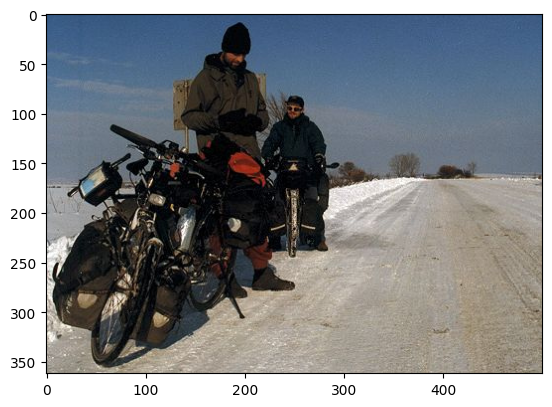

In [72]:
generate_caption(5, unq_valid_imgs.iloc[random.randint(0, 809)]['image'])

>>> Actual Caption:
A white dog fetches a stick as he swims in a lake
A white dog holds a stick while swimming .
A white dog retrieves the stick from the lake for her owner .
A white dog swims with a stick .
White dog retrieving stick from water
>>> Predicted Caption:
1) the wet white puppy walks on gravel beach with stick behind it in its body of it out in water.
2) dog swimming in the deep water.
3) wet white dog running with water.
4) wet white fluffy puppy runs with large black and white markings in its wings in its ocean behind them in body.
5) the dog is walking across shallow water with stick.




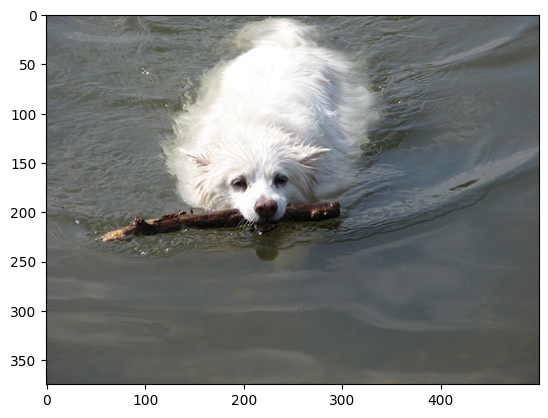

In [52]:
generate_caption(5, unq_valid_imgs.iloc[random.randint(0, 809)]['image'])

>>> Actual Caption:
A brown furry dog is biting a no hair brown dog .
a brown hairy dog nibbles the ear of another dog that is baring its teeth .
A shaggy dog bites the cheek of a short-haired dog .
Two dogs are biting each other in the snow .
Two dogs are fighting in the snow .
>>> Predicted Caption:
1) brown fluffy dog jumps to be yellow and blue toy outside.
2) two dogs play outside on snow.
3) yellow and brown dog are running on path.
4) three dogs are pulling each wearing green jacket on snowy path.
5) two women with yellow pants and tan colored dog play on the ground next to building with large stick behind it in it.




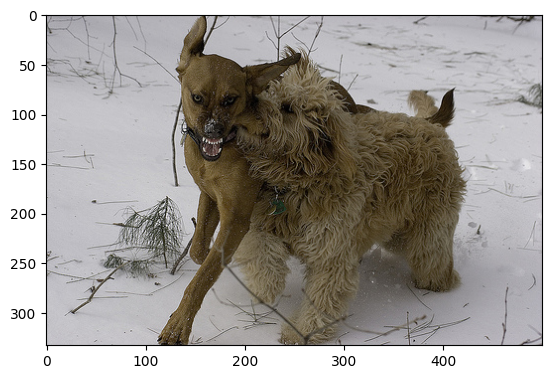

In [53]:
generate_caption(5, unq_valid_imgs.iloc[random.randint(0, 809)]['image'])

>>> Actual Caption:
Girl in a thin rowboat leaving the dock of a lake .
A girl is rowing in a lake .
a girl sits on a skinny canoe .
A woman sits in a rowing scull and looks behind her at a dock .
A woman sitting in a rowboat
>>> Predicted Caption:
1) woman sits on boat and sitting on wooden platform in water.
2) woman is sitting next and man wearing black shorts with white tank boat in the water and black pants is in front of water on his hand.
3) young woman wearing orange shirt sitting next to the man.
4) boy is sitting by the water with his arms spread on.
5) man in blue shorts rides wave while man stands by body of lake with body him on the beach.




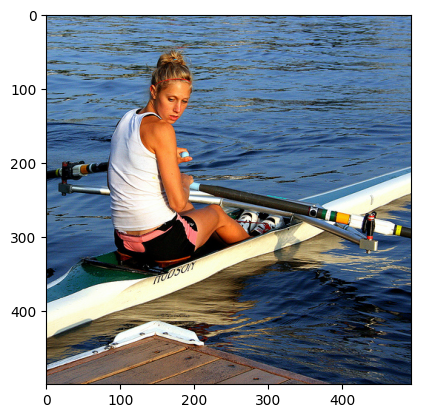

In [56]:
generate_caption(5, unq_valid_imgs.iloc[random.randint(0, 809)]['image'])

>>> Actual Caption:
Two dogs on hind legs with faces near each other on a grassy field .
Two dogs playing .
Two dogs leap toward each other on a grassy lawn .
A black and brown dog is playing with a brown and white dog .
Two dogs are playing on the grass .
>>> Predicted Caption:
1) dog leaps to throw the toy in the grass.
2) the two large dogs play together outside.
3) the dogs run together.
4) two black dogs playing on the green grassy plain on grass.
5) three large dogs run across grassy field with each other in front.




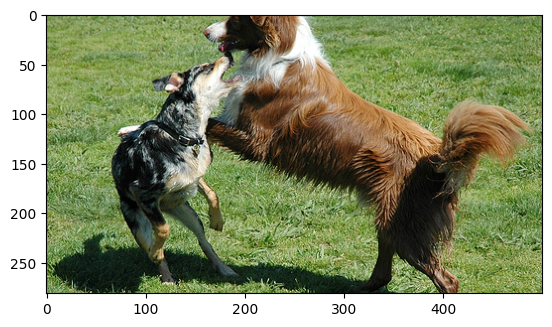

In [57]:
generate_caption(5, unq_valid_imgs.iloc[random.randint(0, 809)]['image'])

>>> Actual Caption:
An overweight woman and man have upset faces as they sit on a bench .
An older woman and an old man sitting down looking unhappy .
An older couple is resting on a bench .
A man and a woman sitting on a bench
An older man and woman sitting on a cement bench with frowns on their faces .
>>> Predicted Caption:
1) two people sit in front of the wall and look out of the camera on it is sitting.
2) group stands on top and looking into microphone.
3) man in suit sits at the park in front of large building in red and black.
4) two men in jackets sitting and sitting in front of large building.
5) two girls look out at another woman wearing red shirt and black jacket.




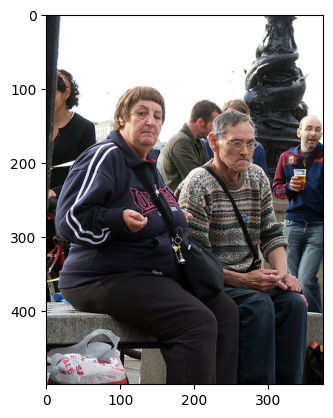

In [59]:
generate_caption(5, unq_valid_imgs.iloc[random.randint(0, 809)]['image'])

>>> Actual Caption:
A boy in a life jacket jumps onto something yellow , out of frame .
A boy wearing a life vest suspended in the air .
A child wearing a white , red , and black life jacket was bounced into the air by something big and yellow .
A child with a floatation vest is being bounced off of something .
The kid in the life vest jumps up in the air .
>>> Predicted Caption:
1) man wearing red shirt and blue jacket jumping with his arm up on it.
2) the boy in red jacket has red ball.
3) two young boys in pink and orange jersey are in field hockey game in an outdoor game of the grass.
4) young boy is jumping into the grass with his racket.
5) little kid playing basketball in the mud.




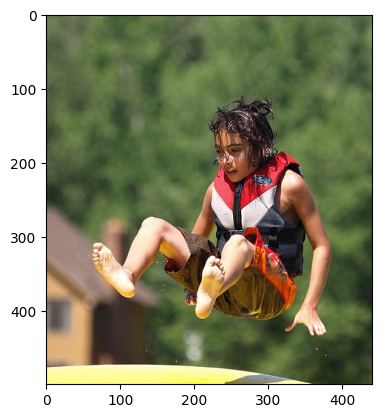

In [73]:
generate_caption(5, unq_valid_imgs.iloc[random.randint(0, 809)]['image'])

>>> Actual Caption:
A man in a large red truck .
A man in a red truck is staring out the driver-side window .
A man looks mysterious in a blue shirt and a red truck for a company called Wilbert .
A truck driver is looking out of the window of his purple truck .
The truck driver pauses for a photo opportunity .
>>> Predicted Caption:
1) young man with his tongue hanging on his head while the stands on the side.
2) woman stands in an obstacle with truck in the background.
3) woman is standing in line on the street with two other children in the background on her.
4) woman sits inside an umbrella on train station.
5) three children sit on the truck while others look out on the phone.




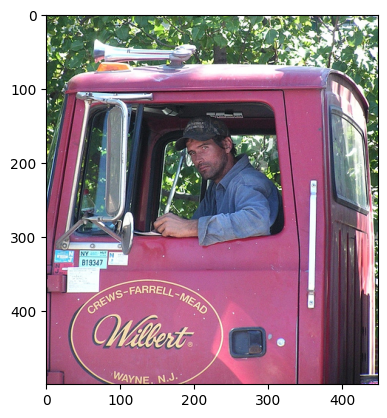

In [74]:
generate_caption(5, unq_valid_imgs.iloc[random.randint(0, 809)]['image'])

>>> Actual Caption:
Boys playing tag football run down the field .
One kid is chasing another kid who is holding a football .
One kid is running across a field carrying a football while another is close behind grabbing for his flags .
Two children playing tag football .
Two little boys play football on green grass .
>>> Predicted Caption:
1) boy is jumping over soccer game of green grass and holding football.
2) soccer game is running through the field while holding the soccer game.
3) the two soccer players are playing with each others in the park one of one in the grass one.
4) boy in an uniform running through the park with ball on his hind legs and other players.
5) two soccer are in the soccer uniforms run for an orange soccer ball in front of him while others watch from one with one with each spectators.




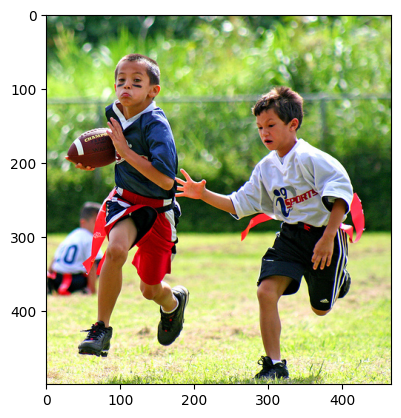

In [77]:
generate_caption(5, unq_valid_imgs.iloc[random.randint(0, 809)]['image'])

>>> Actual Caption:
A child walking on rocks .
A girl walking on rocks .
A little girl in a white coat plays in a rock garden .
A young girl walks across big rocks .
Little girl walking on rocks near grassy area beside building .
>>> Predicted Caption:
1) young girl in jeans and black top sitting at table.
2) two girls are playing outside.
3) young boy is standing on rock with his hind on it in shallow grass in the background and red shirt.
4) young girl in jeans runs with her arms out in shallow setting at it beside her mouth and woman sit.
5) two boys play on rocks in the woods in the background.




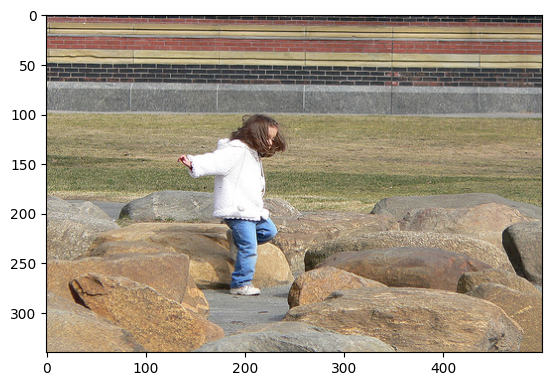

In [75]:
generate_caption(5, unq_valid_imgs.iloc[random.randint(0, 809)]['image'])

>>> Actual Caption:
The little girl played on the swing .
a young girl in a pick shirt swinging up in the air on a swing set
The girl is on a swing .
a girl wearing pink swings on a swing .
A little girl is swinging high above a wooden fence on the swing .
>>> Predicted Caption:
1) the little boys play on wooden wooden wooden structure on park in front of wooden structure with the trees.
2) man in blue shorts is doing handstand on bench and jumping high.
3) woman in blue shirt jumps off rock wall and looks to cross the ground in her hand to the distance by the side by an obstacle.
4) boy wearing shorts is climbing on wooden wooden wall.
5) the young boy in blue shorts does back.




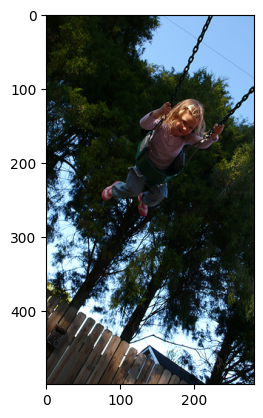

In [76]:
generate_caption(5, unq_valid_imgs.iloc[random.randint(0, 809)]['image'])